# 1.  Vehicle Loads and Design

In Golden, CO, air density is going to be a bit lower than at sea level, we will hard code it at 1.01 kg•m<sup>-3</sup>.

In [379]:
# constants
G = 9.81  # m/s^2
R_air = 8314.5 / 28.96  # gas constant for air (in J/kg*K)
energydensity_fuel = 34.2  # gasoline energy density (in MJ/l)

# ambient air conditions
ambient = dict(
    v_air=0,  # ambient wind velocity where negative is headwind  (in m/s)
    # temp=25 + 273.15,  # ambient air temperature (in K)
    # pressure=98000,  # ambient air pressure (in Pa)
    rho=1.01,  # hardcoding in air density kg/m^3
)
# ambient["rho"] = ambient["pressure"] / (
#     R_air * ambient["temp"]
# )  # ambient air density (in kg/m^3)


# subaru outback
vehicle_outback = dict(
    mass=1800,  # vehicle mass [kg]
    C_drag=0.37,  # drag coefficient [-]
    A_front=2.56,  # frontal area for drag [m^2]
    C_roll_0=0.011,  # tire rolling resistance coefficient [-]
    p_tire=3.0,
    Wdot_access=280,  # average accessory loads [W]
    eta_elec=0.70,  # efficiency of alternator or electrical system for accessories [-]
    # To be filled in later
    Wdot_drag=[0, 0],
    Wdot_roll=[0, 0],
    Wdot_accel=[0, 0],
    Wdot_access_vec=[0, 0],
    Wdot=[0, 0],
    x=[0, 0],
    E_veh=[0, 0],
    E_fuel=[0, 0],
    kmperliter=[0, 0],
    mpg=[0, 0],
)

#### Test Driving Schedules

Loading in the driving schedules and making sure they look correct.

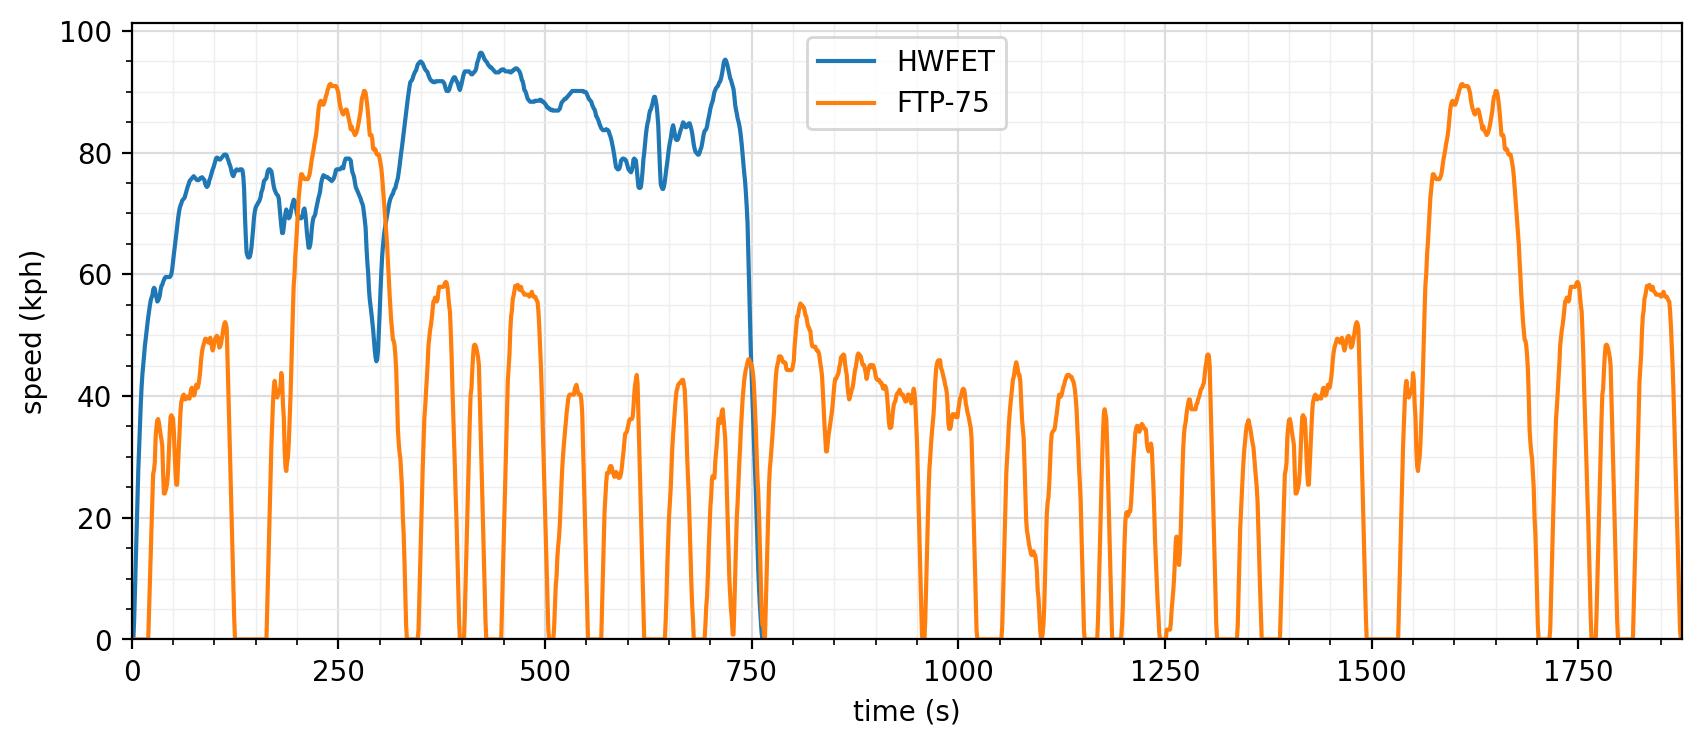

In [459]:
import pandas as pd
import matplotlib.pyplot as plt
import hw_utils
import matplotlib_inline
from matplotlib.colors import hsv_to_rgb

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

hwfet_schedule = pd.read_csv("./hw2_hwfet.csv", usecols=[0, 1])
ftp_schedule = pd.read_csv("./hw2_ftp.csv", usecols=[0, 1])

hwfet_schedule.head()
plt.figure(figsize=(10, 4))
plt.plot(hwfet_schedule["speed (kph)"], label="HWFET")
plt.plot(ftp_schedule["speed (kph)"], label="FTP-75")
plt.legend()
plt.xlabel("time (s)")
plt.ylabel("speed (kph)")
plt.xlim(0, 1875)
plt.ylim(0)
hw_utils.nice_grid(plt)

Let's do a sanity check that our distances traveled for these driving schedules are the same as what is given on epa.gov.

(0.0, 1875.0)

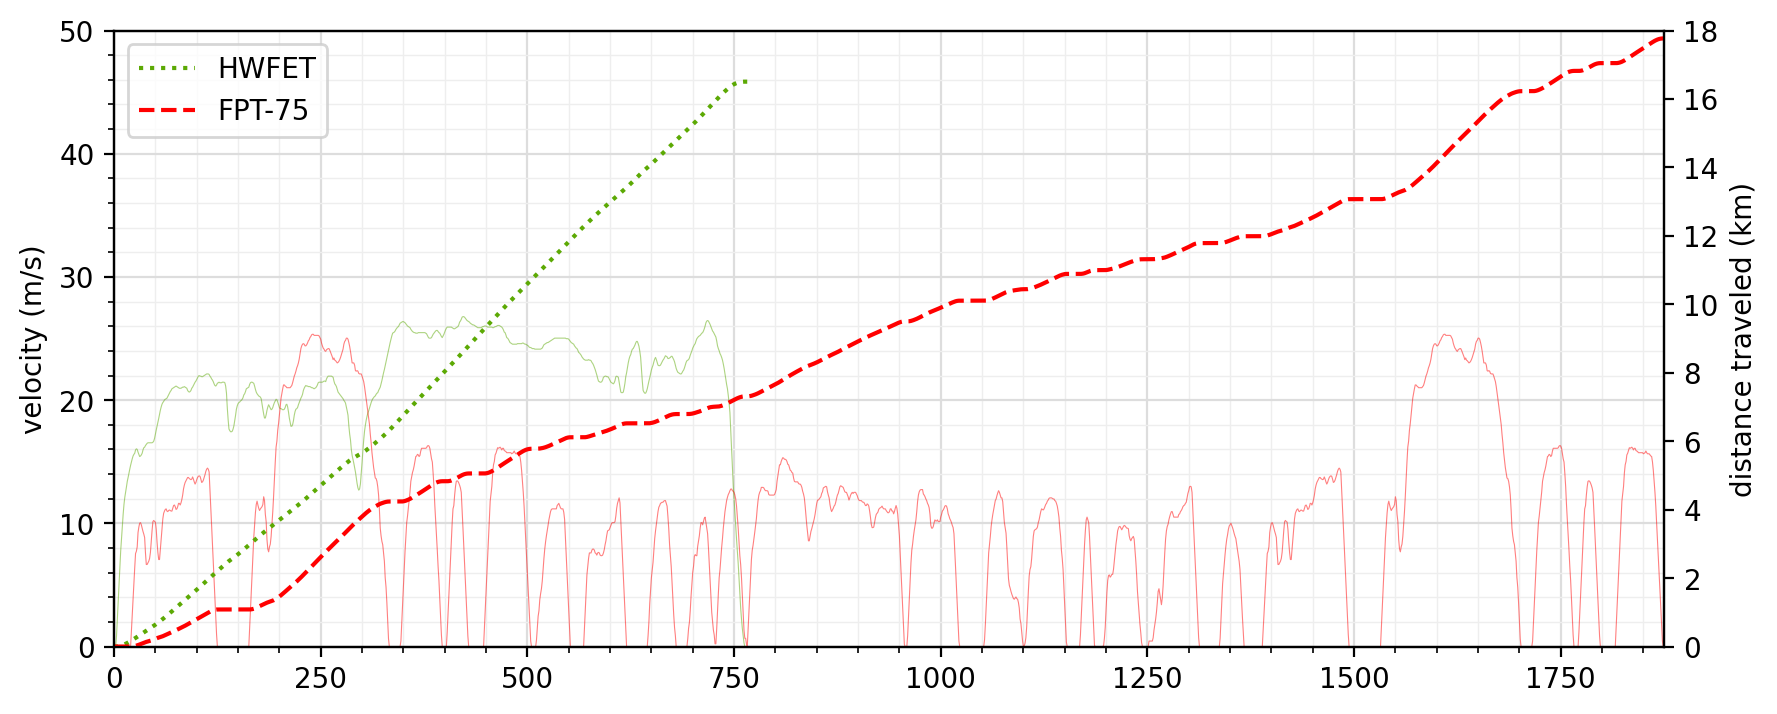

In [458]:
import numpy as np
from scipy.integrate import solve_ivp


kph_to_mps = 0.277778  # 1 kph = 0.277778 m/s

cycle = dict(
    time=[hwfet_schedule["time"].values, ftp_schedule["time"].values],
    mps=[
        hwfet_schedule["speed (kph)"] * kph_to_mps,
        ftp_schedule["speed (kph)"] * kph_to_mps,
    ],
    name=["HWFET", "FTP-75"],
)

hwfet_integral = np.array([0, *np.cumsum(cycle["mps"][0])]) / 1000.0
ftp_integral = np.array([0, *np.cumsum(cycle["mps"][1])]) / 1000.0


fig, ax1 = plt.subplots(figsize=(10, 4))
ax2 = ax1.twinx()


ax1.plot(cycle["mps"][0], color="xkcd:leaf green", alpha=0.5, linewidth=0.4)
ax1.plot(cycle["mps"][1], color="red", alpha=0.5, linewidth=0.4)
ax2.plot(hwfet_integral, linestyle="dotted", color="xkcd:leaf green", label="HWFET")
ax2.plot(ftp_integral, linestyle="dashed", color="red", label="FPT-75")
ax1.set_ylabel("velocity (m/s)")
hw_utils.nice_grid(ax1)


plt.legend()
ax2.set_ylabel("distance traveled (km)")
ax1.set_ylim(0, 50)
ax2.set_ylim(0, 18)
ax1.set_xlim(0, 1875)

Below you will see the road load equation with  instantaneous η<sub>tr</sub> now being considered in the calculation.

In [460]:
#  instantaneous powertrain efficiency with wdot_veh in kW
def instantaneous_eta_tr(wdot_veh, **kwargs):
    a = kwargs.get("a", 0.4)
    wdot_1 = kwargs.get("wdot_1", 210)
    wdot_2 = kwargs.get("wdot_2", 18)

    eff = a * ((np.exp(-wdot_veh / wdot_1)) - np.exp(-wdot_veh / wdot_2))
    return 0.0001 if eff == 0.0 else eff
    # return a * ((np.exp(-wdot_veh / wdot_1)) - np.exp(-wdot_veh / wdot_2))


etas_0 = []
t_0 = []
etas_1 = []
t_1 = []


# model from Fiori et al
def calculate_regen_braking_efficiency(dv_dt):
    return 1 / np.exp(0.0411 / np.abs(dv_dt))


def calculate_acceleration_term(dv_dt, regen_braking_on):
    if regen_braking_on:
        if dv_dt >= 0:
            return dv_dt
        else:
            regen_braking_efficiency = calculate_regen_braking_efficiency(dv_dt)
            return regen_braking_efficiency * dv_dt
    else:
        return max(0, dv_dt)


# Function to solve system of 1st-order linear ODEs with oscillatory forcing
def dydt_vehicle(
    t, y, cycle, vehicle, amb, index, idx, eta_tr_params, regen_braking_on
):
    global etas_0, etas_1, t_0, t_1
    # Determine instantaneous values of velocity, acceleration, and road angle.
    dydt = [0] * len(y)

    v_veh = np.interp(t, cycle["time"][idx], cycle["v_veh"])
    dv_vehdt = np.interp(t, cycle["time"][idx], cycle["dv_vehdt"])
    alpha = np.pi / 180 * np.interp(t, cycle["time"][idx], cycle["alpha"])

    # Set instantaneous velocity
    dydt[index["x"]] = v_veh

    # Determine instantaneous vehicle load (power demand for engine)
    if v_veh > 0:
        C_roll = vehicle["C_roll_0"] + 1 / vehicle["p_tire"] * (
            0.01 + 9.5e-7 * v_veh**2
        )
        Wdot_veh = (
            vehicle["mass"]
            * (
                calculate_acceleration_term(dv_vehdt, regen_braking_on)
                + G * np.sin(alpha)
                + C_roll * G * np.cos(alpha)
            )
            + vehicle["C_drag"]
            * vehicle["A_front"]
            * 0.5
            * amb["rho"]
            * (v_veh - amb["v_air"]) ** 2
        ) * v_veh + vehicle["Wdot_access"] / vehicle["eta_elec"]
    else:
        Wdot_veh = vehicle["Wdot_access"] / vehicle["eta_elec"]

    dydt[index["E_veh"]] = Wdot_veh

    # Determine power train efficiency and instantaneous fuel energy demand rate
    eta = instantaneous_eta_tr(Wdot_veh / 1000, **eta_tr_params)
    if idx == 0:
        etas_0 = etas_0 + [eta]
        t_0 = t_0 + [t]
    elif idx == 1:
        etas_1 = etas_1 + [eta]
        t_1 = t_1 + [t]

    dydt[index["E_fuel"]] = Wdot_veh / eta
    return dydt


# Set up indices and intial conditions for solution vector y(t) = [x; Wdot_veh]'
index = dict(x=0, E_veh=1, E_fuel=2)
y_0 = [None] * 3
y_0[index["x"]] = 0
y_0[index["E_veh"]] = 0
y_0[index["E_fuel"]] = 0


def calculate_loads(vehicle, eta_tr_params={}, regen_braking_on=False):
    for idx, speed in enumerate(cycle["mps"]):
        arr_length = len(speed)
        time = cycle["time"][idx]

        #  driving cycle vehicle velocities [m/s]
        cycle["v_veh"] = speed
        # road angle to horizontal  [deg.]
        cycle["alpha"] = [0] * arr_length
        # Calculate vehicle acceleration and identify times when acceleration is positive
        cycle["dv_vehdt"] = np.gradient(cycle["v_veh"])

        # Call an ODE integrator to solve for y(t)
        sol = solve_ivp(
            dydt_vehicle,
            [0, time[-1] + 1],
            y_0,
            "RK45",
            time,
            args=(cycle, vehicle, ambient, index, idx, eta_tr_params, regen_braking_on),
            rtol=1e-4,
            atol=1e-4,
        )

        vehicle["x"][idx] = sol.y[index["x"]] / 1000
        vehicle["E_veh"][idx] = sol.y[index["E_veh"]] / 1000
        vehicle["E_fuel"][idx] = sol.y[index["E_fuel"]] / 1000
        vehicle["kmperliter"][idx] = [0] * len(cycle["mps"][idx])
        vehicle["kmperliter"][idx] = (
            1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)
        )
        vehicle["mpg"][idx] = 2.35215 * vehicle["kmperliter"][idx]

        #  Allocate memory for vectors for calculating vehicle power requirements
        vehicle["Wdot_drag"][idx] = np.zeros(arr_length)
        vehicle["Wdot_roll"][idx] = np.zeros(arr_length)
        vehicle["Wdot_accel"][idx] = np.zeros(arr_length)

        # Calculate instantaneous power (in kW) to overcome forces on vehicle
        #   and integrate to get total work required (in kWh)
        vehicle["Wdot_drag"][idx] = (
            (
                np.array(
                    vehicle["C_drag"]
                    * vehicle["A_front"]
                    * 0.5
                    * ambient["rho"]
                    * (np.array(cycle["v_veh"]) - ambient["v_air"]) ** 2
                )
            )
            * cycle["v_veh"]
            / 1000
        )

        C_roll = vehicle["C_roll_0"] + (
            1 / vehicle["p_tire"] * (0.01 + 9.5e-7 * np.array(cycle["v_veh"]) ** 2)
        )
        vehicle["Wdot_roll"][idx] = (
            vehicle["mass"]
            * C_roll
            * (G * np.cos(cycle["alpha"]) * cycle["v_veh"] / 1000)
        )
        vehicle["Wdot_accel"][idx] = (
            vehicle["mass"]
            * np.array(
                [
                    calculate_acceleration_term(dv_dt, regen_braking_on)
                    for dv_dt in cycle["dv_vehdt"]
                ]
            )
            * cycle["v_veh"]
            / 1000
        )
        vehicle["Wdot_access_vec"][idx] = (
            np.ones(len(speed)) * vehicle["Wdot_access"] / vehicle["eta_elec"] / 1000
        )
        vehicle["Wdot"][idx] = (
            vehicle["Wdot_drag"][idx]
            + vehicle["Wdot_roll"][idx]
            + vehicle["Wdot_accel"][idx]
            + vehicle["Wdot_access_vec"][idx]
        )

    return vehicle


vehicle_outback = calculate_loads(vehicle_outback)

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_98276/903850401.py:122: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


Let's plot the powertrain efficiency throughout both cycles to make sure we are seeing reasonable values.

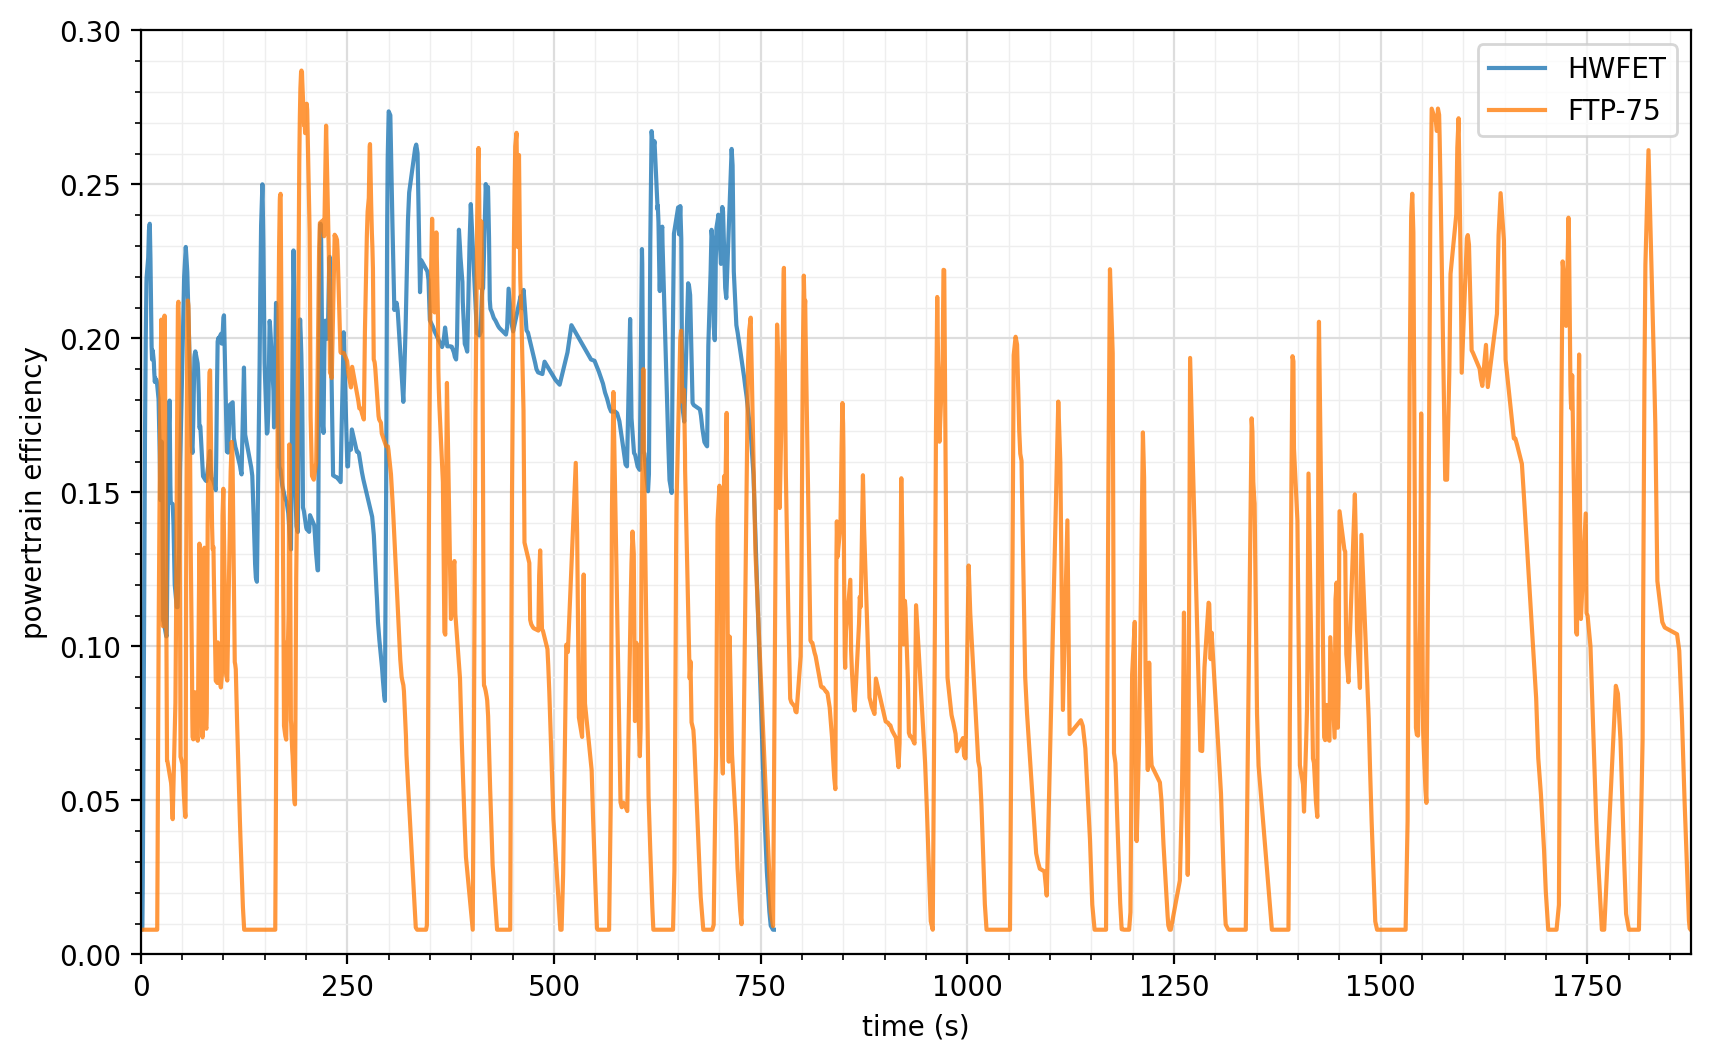

In [461]:
indices = np.argsort(t_0)
t_0 = np.array(t_0)[indices]
etas_0 = np.array(etas_0)[indices]

indices = np.argsort(t_1)
t_1 = np.array(t_1)[indices]
etas_1 = np.array(etas_1)[indices]

plt.figure(figsize=(10, 6))
plt.plot(t_0, etas_0, label=cycle["name"][0], alpha=0.8)
plt.plot(t_1, etas_1, label=cycle["name"][1], alpha=0.8)
plt.ylim(0, 0.3)
plt.xlim(0, 1875)
plt.xlabel("time (s)")
plt.ylabel("powertrain efficiency")
plt.legend()
hw_utils.nice_grid(plt)

Ok, with max powertrain efficiency looking like about 0.28, things are looking good.

Let's now make the plots that are actually asked for in problem 1a.
### First, Instantaneous Vehicle Loads

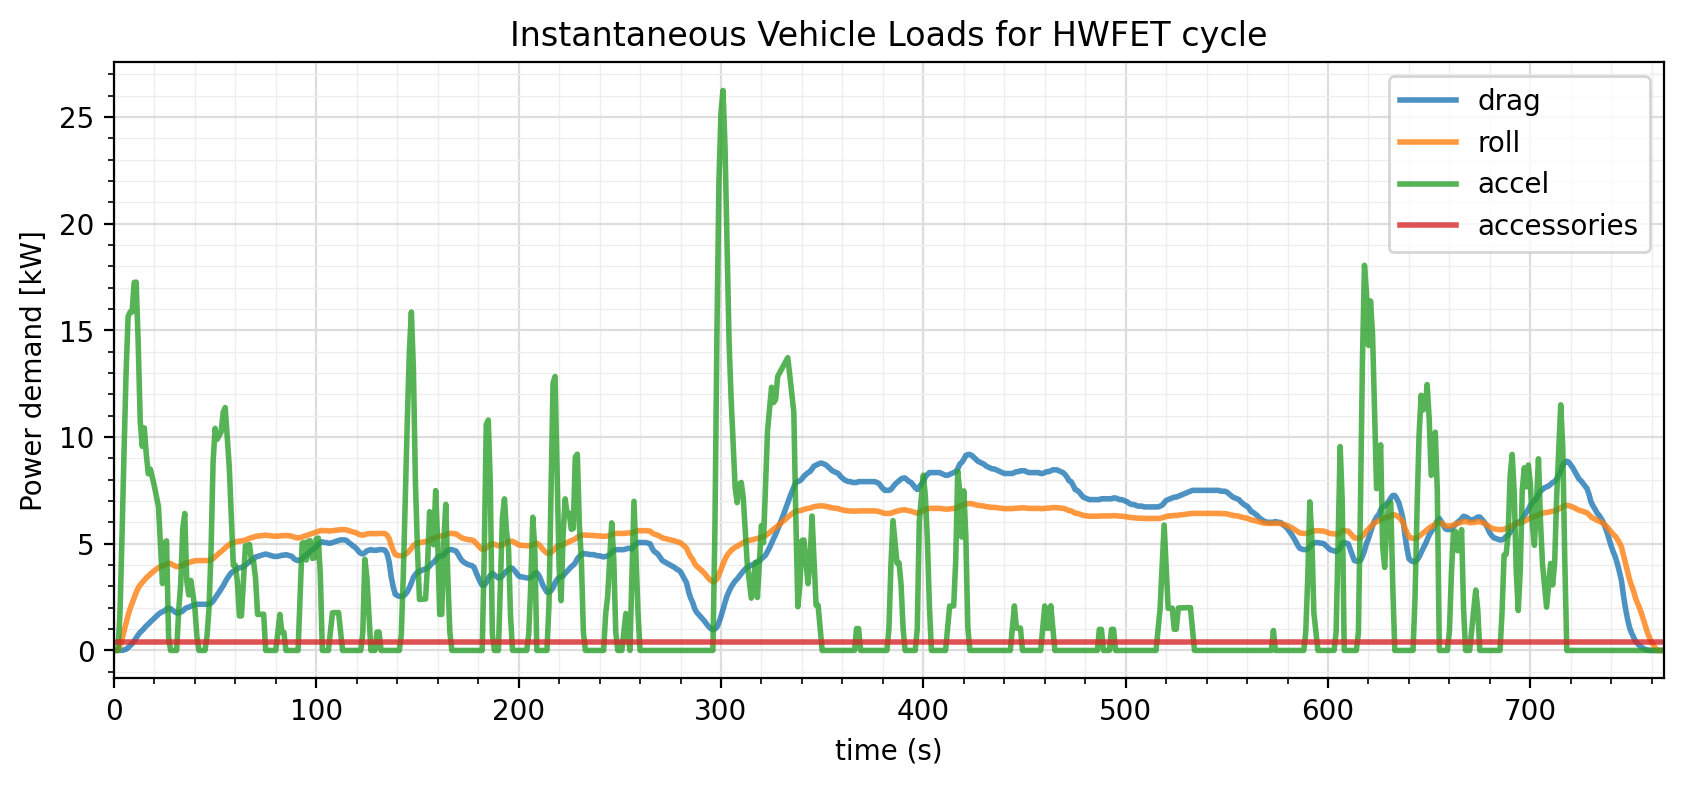

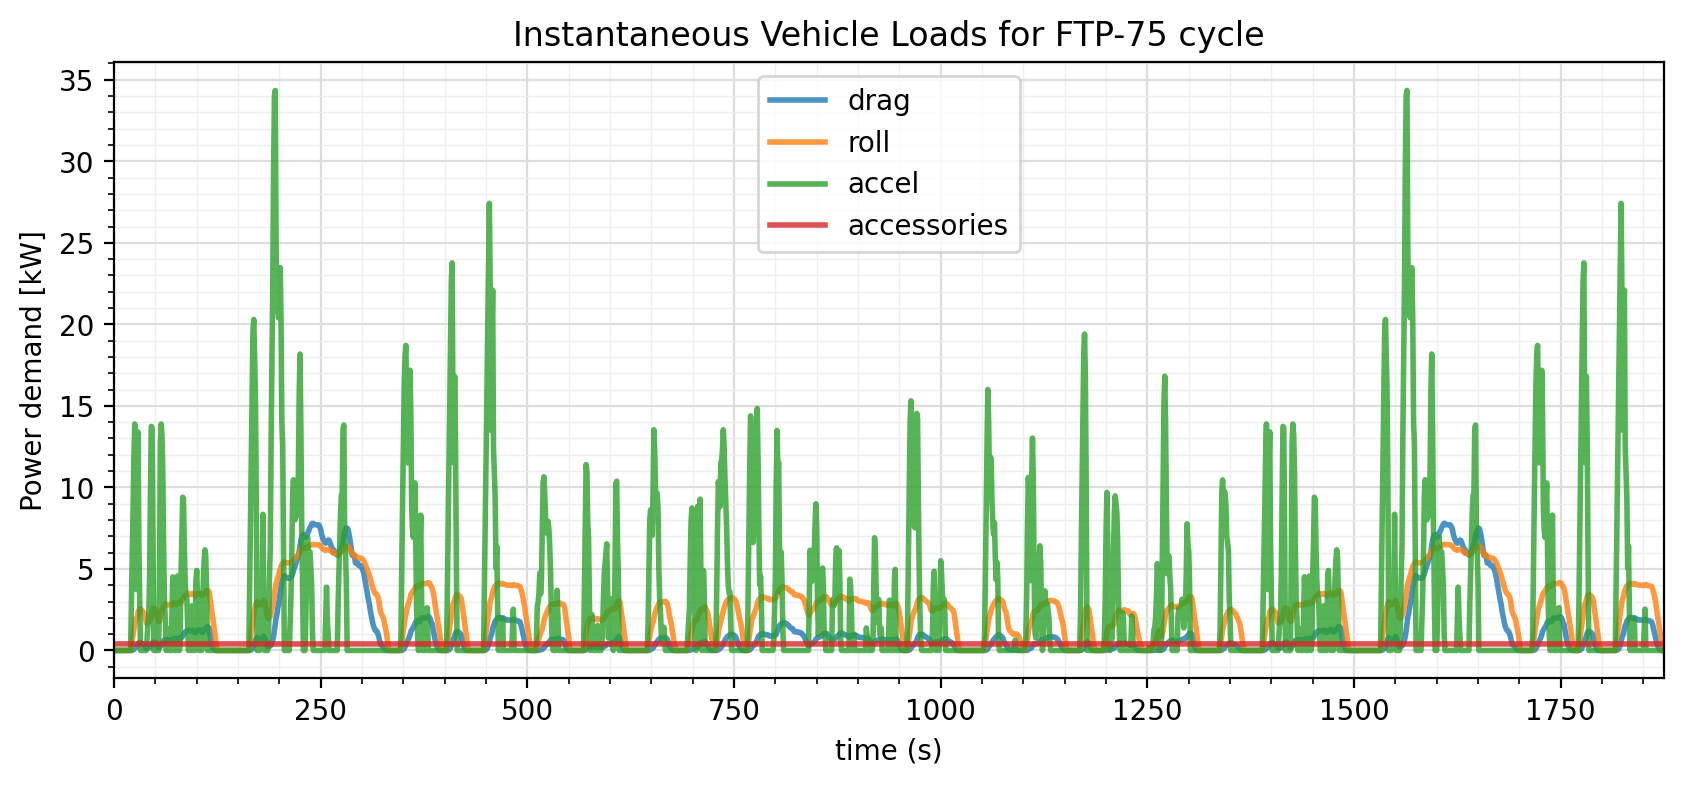

In [462]:
# Plot instantaneous power required for each load for each cycle
for i in [0, 1]:
    plt.figure(figsize=(10, 4))
    plt.plot(
        cycle["time"][i],
        vehicle_outback["Wdot_drag"][i],
        label="drag",
        linewidth=2,
        alpha=0.8,
    )
    plt.plot(
        cycle["time"][i],
        vehicle_outback["Wdot_roll"][i],
        label="roll",
        linewidth=2,
        alpha=0.8,
    )
    plt.plot(
        cycle["time"][i],
        vehicle_outback["Wdot_accel"][i],
        label="accel",
        linewidth=2,
        alpha=0.8,
    )
    plt.plot(
        cycle["time"][i],
        vehicle_outback["Wdot_access_vec"][i],
        label="accessories",
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("Power demand [kW]")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.legend()
    plt.title(f'Instantaneous Vehicle Loads for {cycle["name"][i]} cycle')

### Second, Integrated Load

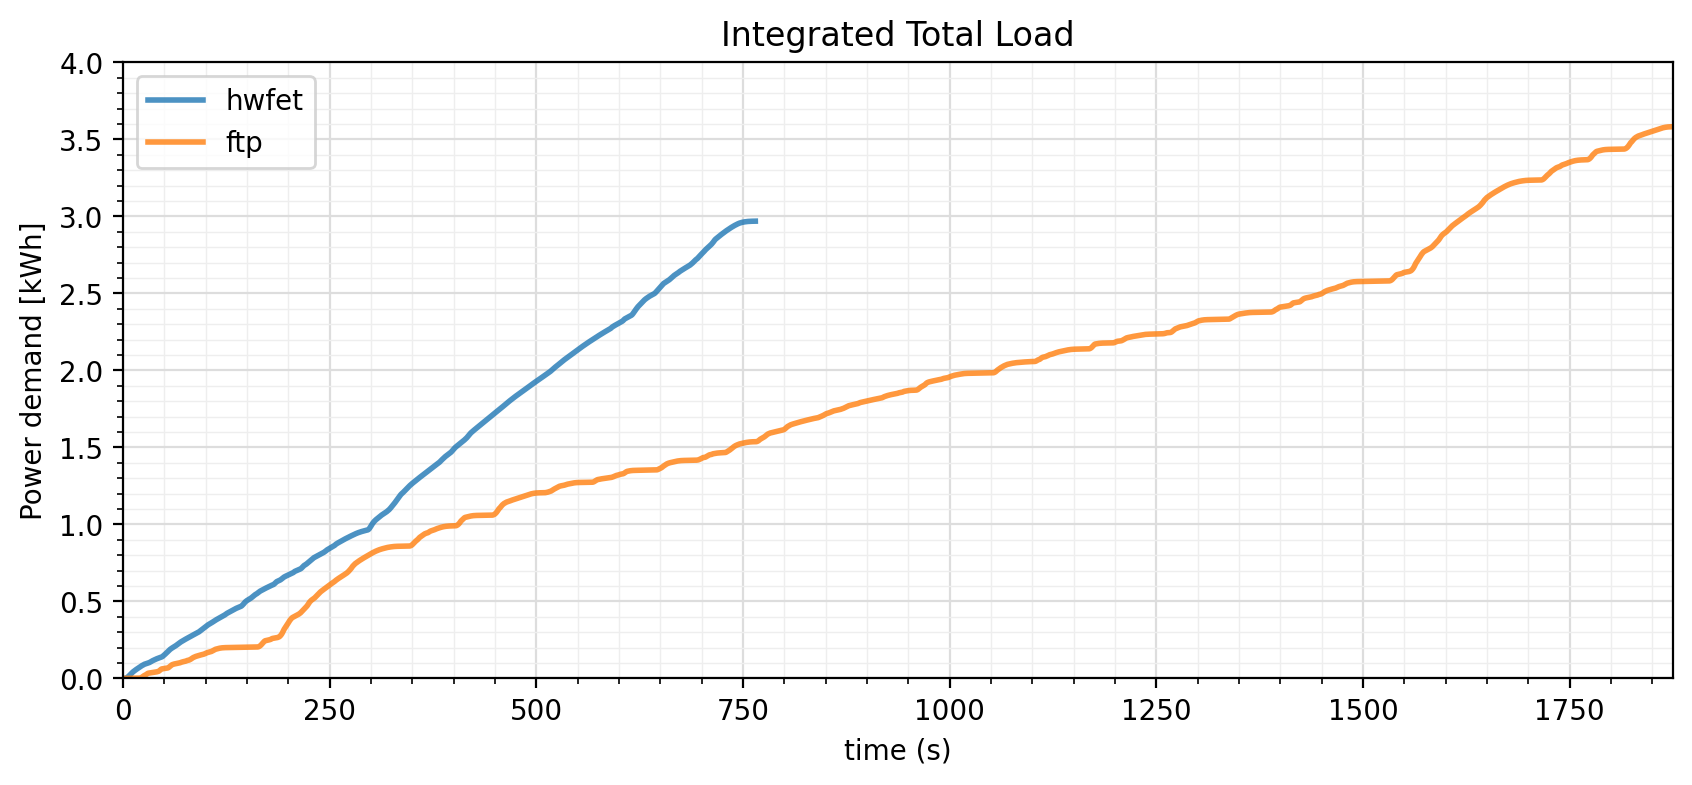

In [385]:
plt.figure(figsize=(10, 4))
for i in [0, 1]:
    plt.plot(
        cycle["time"][i],
        np.cumsum(vehicle_outback["Wdot"][i]) / 3600,
        label=cycle["name"][i],
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("Power demand [kWh]")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.ylim(0, 4)
    plt.legend()
    plt.title("Integrated Total Load")

### Third, fuel economy


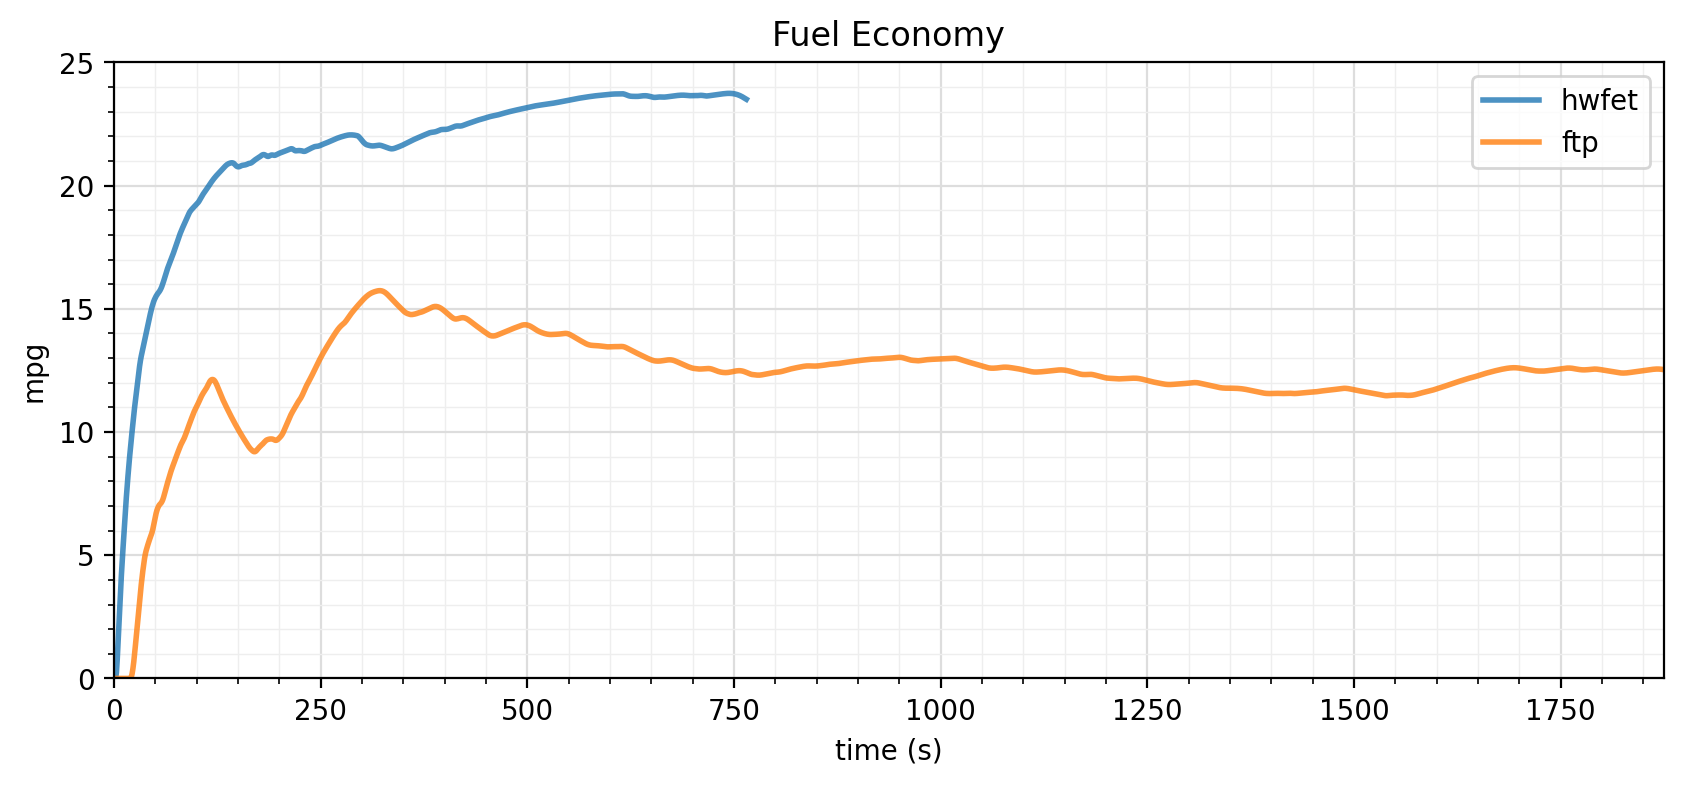

In [386]:
plt.figure(figsize=(10, 4))
for i in [0, 1]:
    plt.plot(
        cycle["time"][i],
        vehicle_outback["mpg"][i],
        label=cycle["name"][i],
        linewidth=2,
        alpha=0.8,
    )
    plt.xlabel("time (s)")
    plt.ylabel("mpg")
    hw_utils.nice_grid(plt)
    plt.xlim(0, len(cycle["time"][i]))
    plt.ylim(0, 25)
    plt.legend()
    plt.title("Fuel Economy")

## 1b. Improving Fuel Economy

### <em>C<sub>roll</sub></em>

First, let's look into reducing rolling the rolling resistance coefficient <em>C<sub>roll</sub></em>. This number could be reduced by changing to less grippy tires, or maybe elimanted altogether if the vehicle could hover.

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_98276/903850401.py:122: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


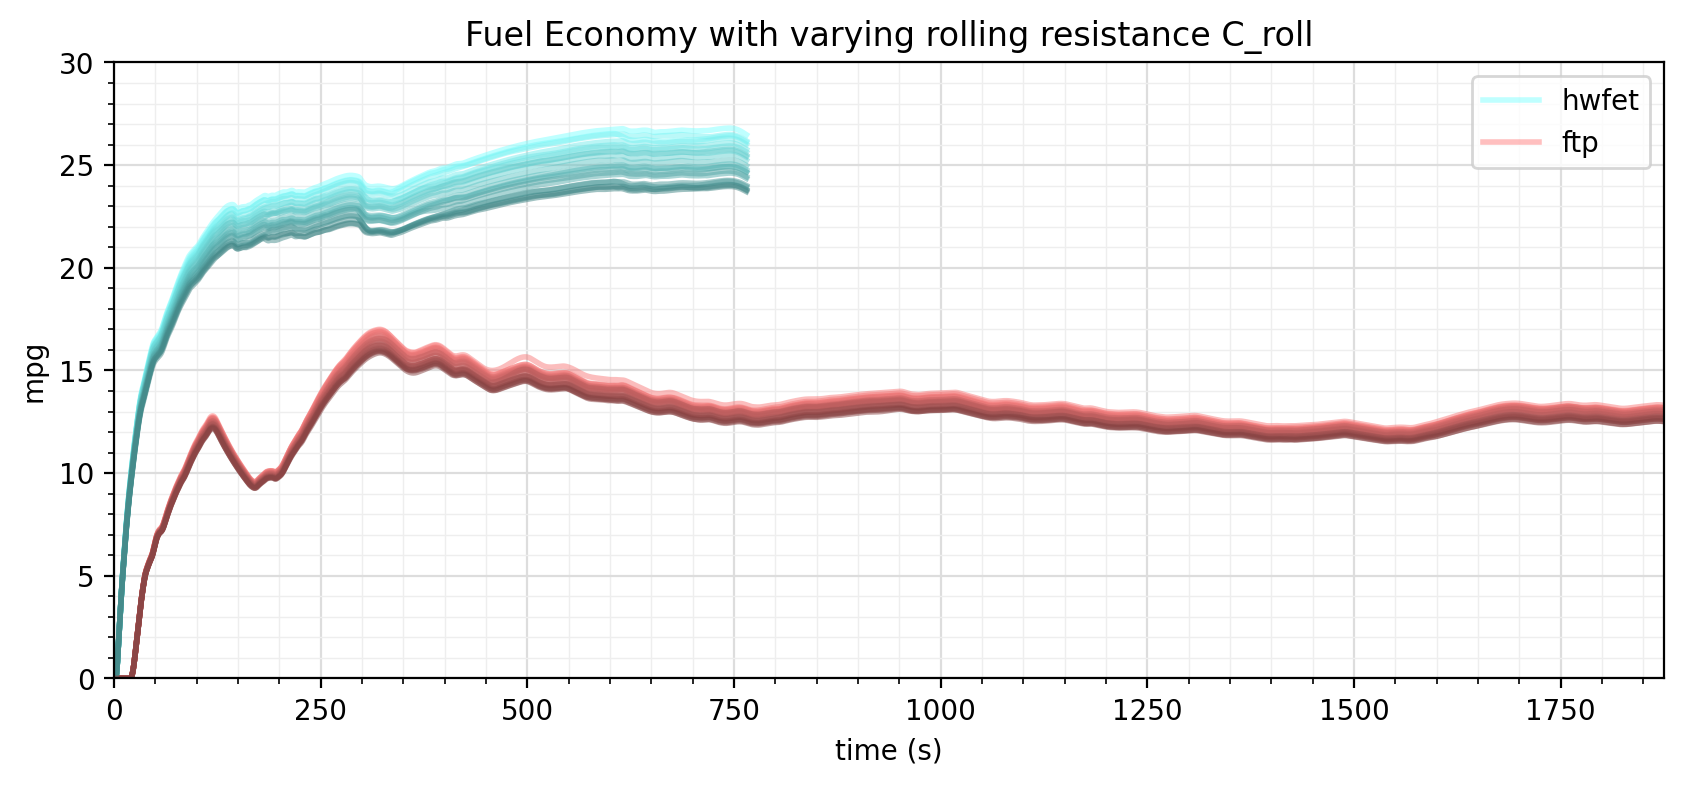

In [433]:
import copy

def change_c_roll(c_roll):
    v = copy.deepcopy(vehicle_outback)
    v["C_roll_0"] = c_roll
    return v


c_roll_max = vehicle_outback["C_roll_0"]
slippery_vehicles = list(map(change_c_roll, np.arange(0, c_roll_max, c_roll_max / 20)))

plt.figure(figsize=(10, 4))
for v in slippery_vehicles:
    v = calculate_loads(v)
    for i in [0, 1]:
        color_rgb = hsv_to_rgb(
            [0.5 if i == 0 else 1, 0.5, 1 - 0.5 * v["C_roll_0"] / c_roll_max]
        )
        plt.plot(
            cycle["time"][i],
            v["mpg"][i],
            linewidth=2,
            color=color_rgb,
            alpha=0.5,
            label=cycle["name"][i] if v["C_roll_0"] < 0.0005 else None,
        )
plt.xlabel("time (s)")
plt.ylabel("mpg")
hw_utils.nice_grid(plt)
plt.xlim(0, len(cycle["time"][i]))
plt.ylim(0, 30)
plt.legend()
plt.title("Fuel Economy with varying rolling resistance C_roll");

The plot is showing lower values of <em>C<sub>roll</sub></em> with a lighter color. For the HWFET schedule, fuel economy increases about 3 mpg as <em>C<sub>roll</sub></em> approaches zero, but for the FTP schedule we only see gains around 1 mpg.

### <em>m<sub>veh</sub></em>

Second, let's try reducing the mass of the vehicle.

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_98276/503172144.py:122: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


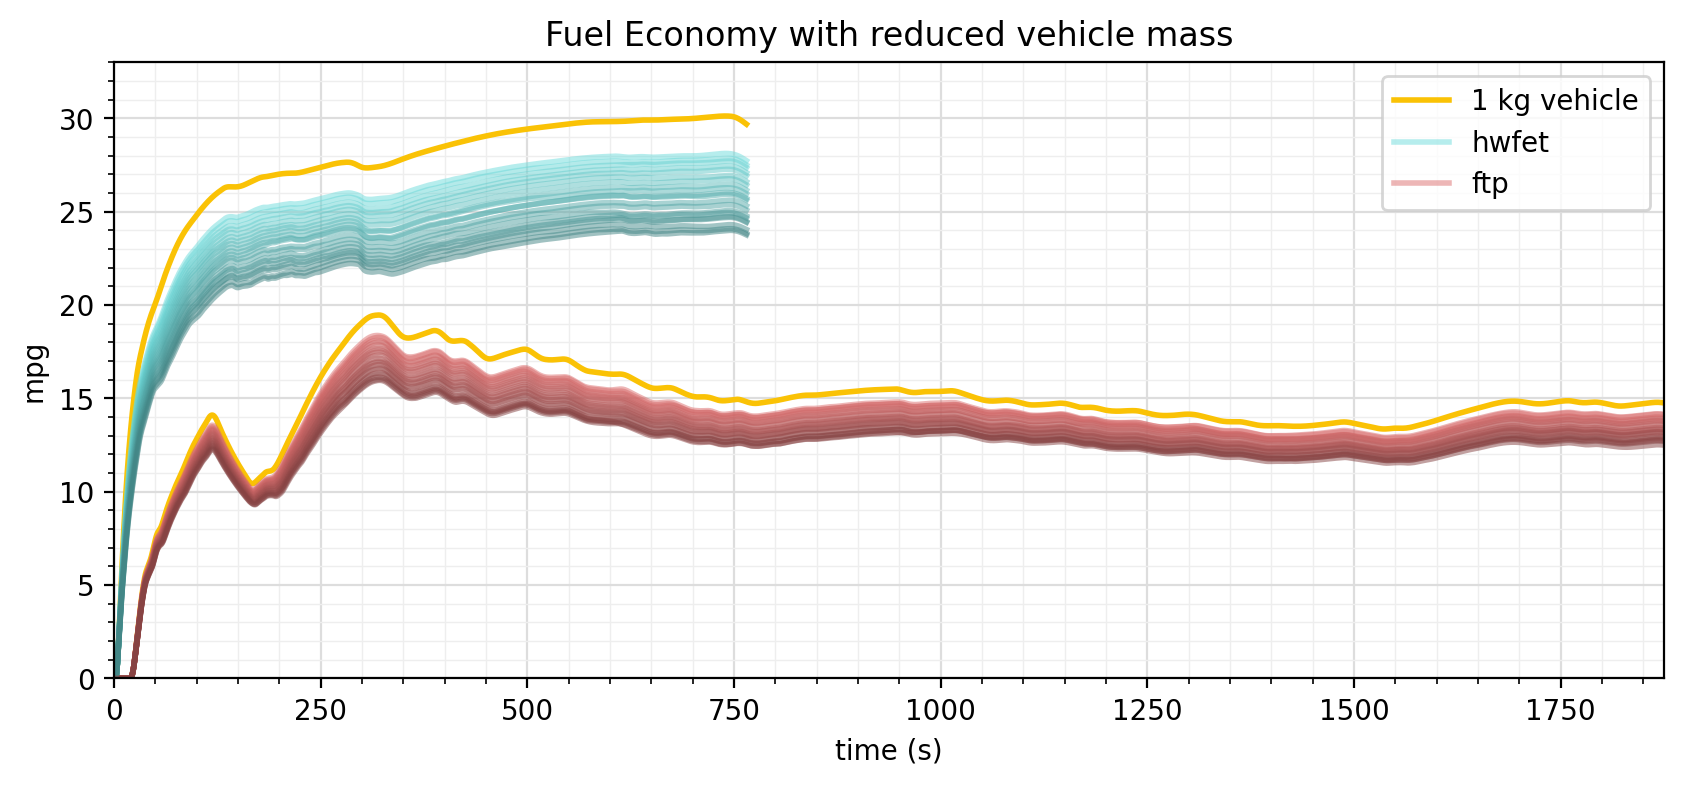

In [388]:
def change_m_veh(m):
    v = copy.deepcopy(vehicle_outback)
    v["mass"] = m
    return v


m_veh_max = vehicle_outback["mass"]
light_vehicles = list(
    map(change_m_veh, np.arange(500, m_veh_max, (m_veh_max - 500) / 20))
)

plt.figure(figsize=(10, 4))

v_superlight = vehicle_outback.copy()
v_superlight["mass"] = 1
v_superlight = calculate_loads(v_superlight)
for i in [0, 1]:
    plt.plot(
        cycle["time"][i],
        v["mpg"][i],
        linewidth=2,
        color="xkcd:goldenrod",
        label="1 kg vehicle" if i == 0 else None,
    )
for v in light_vehicles:
    v = calculate_loads(v)
    for i in [0, 1]:
        color_rgb = hsv_to_rgb(
            [0.5 if i == 0 else 1, 0.5, 1 - 0.5 * v["mass"] / m_veh_max]
        )
        plt.plot(
            cycle["time"][i],
            v["mpg"][i],
            linewidth=2,
            color=color_rgb,
            alpha=0.5,
            label=cycle["name"][i] if v["mass"] == 500 else None,
        )

plt.xlabel("time (s)")
plt.ylabel("mpg")
hw_utils.nice_grid(plt)
plt.xlim(0, len(cycle["time"][i]))
plt.ylim(0, 33)
plt.legend()
plt.title("Fuel Economy with reduced vehicle mass");

This plot is showing lower values of <em>mass<sub>veh</sub></em> with a lighter color, all the way down to 500 kg. For the HWFET schedule, fuel economy increases about 4 mpg as <em>m<sub>veh</sub></em> approaches 500kg, but for the FTP schedule we again see smaller gains, around 2-3 mpg.

I also plotted the fuel economies for an <strong>unreasonable</strong> vehicle mass of 1kg in gold. This shows that there is a limit in gains from mass reduction, due to the terms in the vehicle load equation that are unaffected by vehicle mass (air resistance and accessory loads).

### <em>η<sub>tr</sub></em>

Finally, let's look into improving powertrain efficiency. First let's try to better understand the instantaneous powertrain efficiency relationship.

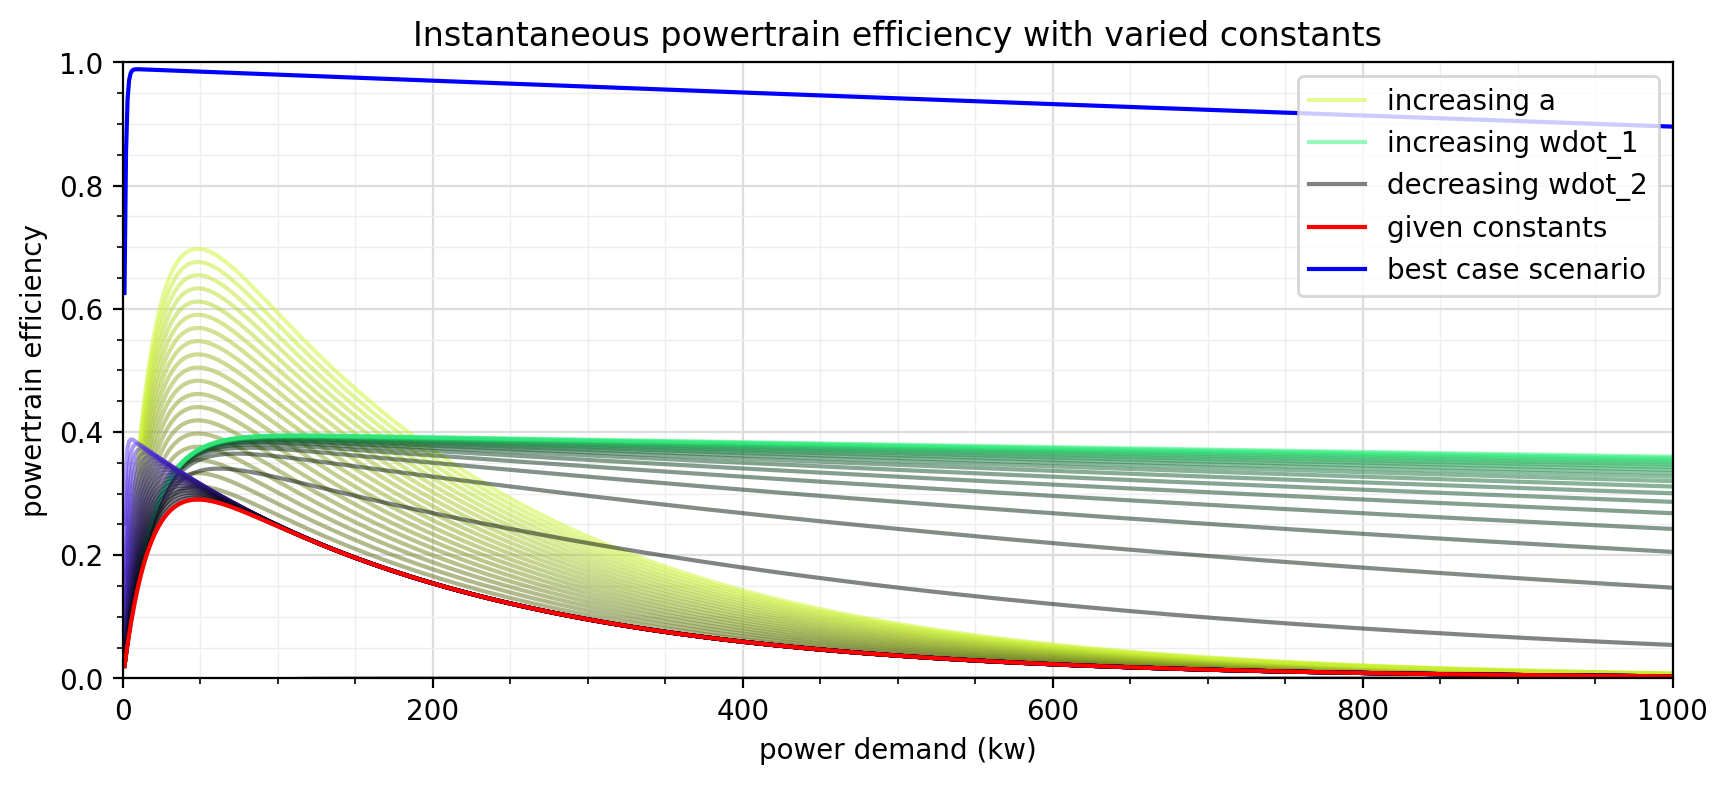

In [389]:
w_veh = list(range(1, 1000))
plt.figure(figsize=(10, 4))
a_range = np.arange(0.4, 0.99, (0.99 - 0.4) / 20)
for a in a_range:
    color_rgb = hsv_to_rgb([0.2, 0.8, a])
    plt.plot(
        w_veh,
        [instantaneous_eta_tr(w, **{"a": a}) for w in w_veh],
        label="increasing a" if a > 0.95 else None,
        color=color_rgb,
        alpha=0.5,
    )

wdot_1_minmax = [1, 10000]
w1_range = np.arange(
    wdot_1_minmax[0], wdot_1_minmax[1], (wdot_1_minmax[1] - wdot_1_minmax[0]) / 20
)
for w1 in w1_range:
    color_rgb = hsv_to_rgb([0.4, 0.8, w1 / wdot_1_minmax[1]])
    plt.plot(
        w_veh,
        [instantaneous_eta_tr(w, **{"wdot_1": w1}) for w in w_veh],
        label="increasing wdot_1" if w1 > wdot_1_minmax[1] - 500 else None,
        color=color_rgb,
        alpha=0.5,
    )

wdot_2_minmax = [1, 18]
w2_range = np.arange(
    wdot_2_minmax[0], wdot_2_minmax[1], (wdot_2_minmax[1] - wdot_2_minmax[0]) / 20
)
for w2 in w2_range:
    color_rgb = hsv_to_rgb([0.7, 0.8, 1 - w2 / wdot_2_minmax[1]])
    plt.plot(
        w_veh,
        [instantaneous_eta_tr(w, **{"wdot_2": w2}) for w in w_veh],
        label="decreasing wdot_2" if w2 > 17 else None,
        color=color_rgb,
        alpha=0.5,
    )

plt.plot(
    w_veh,
    [instantaneous_eta_tr(w) for w in w_veh],
    label="given constants",
    color="red",
)

plt.plot(
    w_veh,
    [
        instantaneous_eta_tr(w, **{"a": 0.99, "wdot_1": 10000, "wdot_2": 1})
        for w in w_veh
    ],
    label="best case scenario",
    color="blue",
)


plt.xlabel("power demand (kw)")
plt.ylabel("powertrain efficiency")
hw_utils.nice_grid(plt)
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.legend()
plt.title("Instantaneous powertrain efficiency with varied constants");

This plot is showing us that <em>a</em> controls the overall scale of the powertrain efficiency, while the constants Ẇ<sub>1</sub> and Ẇ<sub>2</sub> control the shape of the curve. Specifically, a higher value of Ẇ<sub>1</sub> increases efficiency at higher power demands, and a smaller Ẇ<sub>2</sub> increases efficiency at lower power demands. The best case scenario is plotted in blue, where <em>a=1</em>, <em>Ẇ<sub>1</sub>=10,000</em> and <em>Ẇ<sub>2</sub>=1</em>.

Now let's compute fuel economy as all three constants vary in their improving direction.

/var/folders/ht/kgx7l0rn2p5g_jl_0gn7njvm0000gn/T/ipykernel_98276/503172144.py:122: RuntimeWarning: invalid value encountered in divide
  1000 * vehicle["x"][idx] / (vehicle["E_fuel"][idx] / energydensity_fuel)


Text(0.5, 1.0, 'Fuel Economy with improved powertrain efficiency')

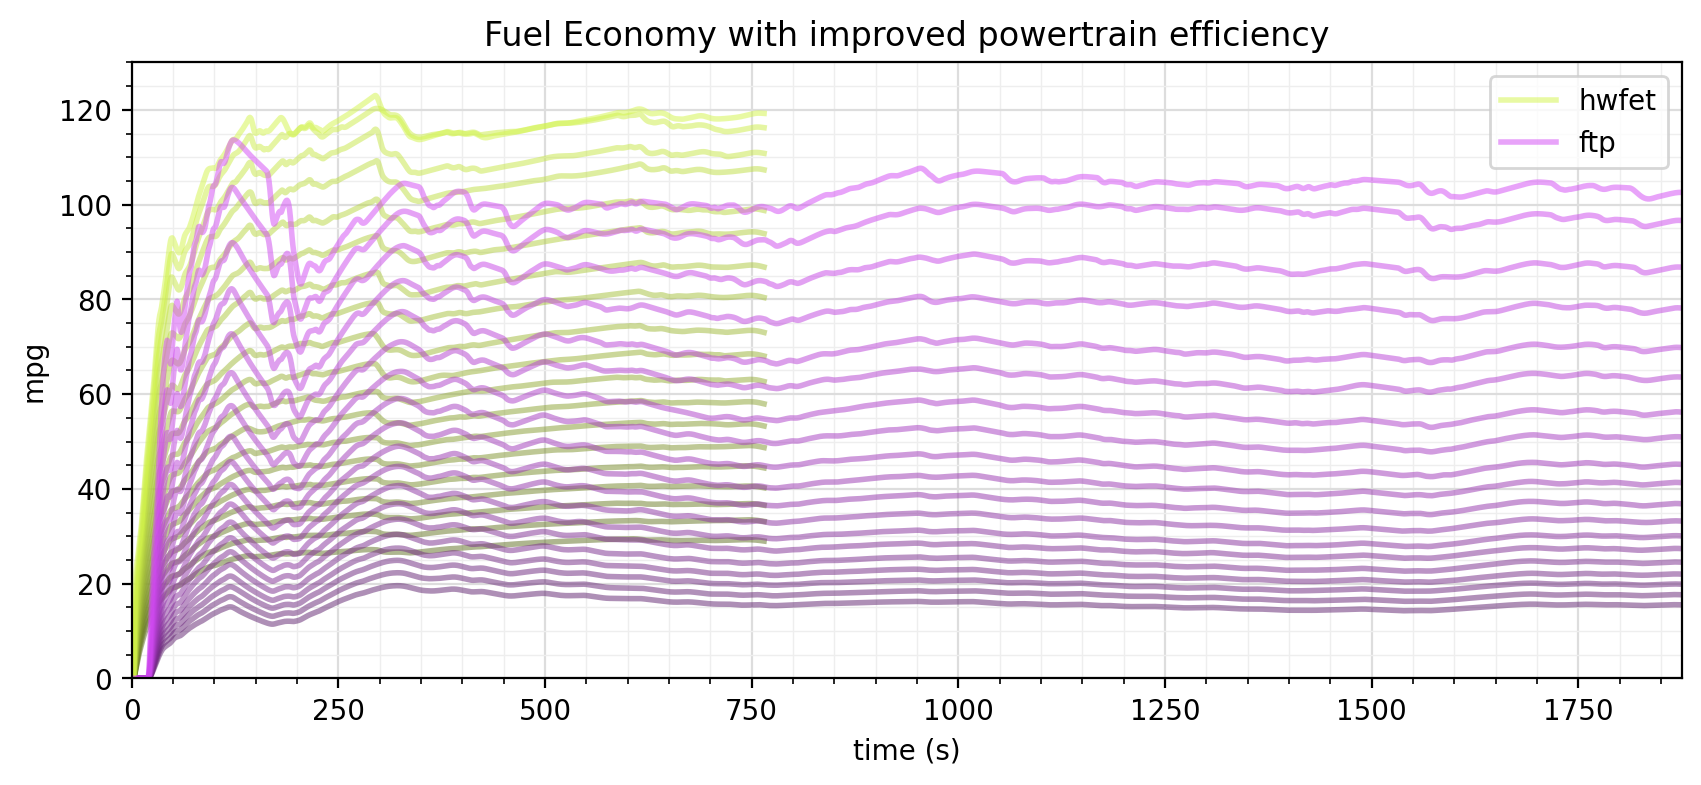

In [390]:
plt.figure(figsize=(10, 4))
for idx, a in enumerate(a_range):
    v = calculate_loads(
        vehicle_outback,
        {"a": a, "wdot_1": w1_range[idx], "wdot_2": np.flip(w2_range)[idx]},
    )
    for i in [0, 1]:
        color_rgb = hsv_to_rgb([0.2 if i == 0 else 0.8, 0.7, a])
        plt.plot(
            cycle["time"][i],
            v["mpg"][i],
            linewidth=2,
            color=color_rgb,
            alpha=0.5,
            label=cycle["name"][i] if a > 0.95 else None,
        )

plt.xlabel("time (s)")
plt.ylabel("mpg")
hw_utils.nice_grid(plt)
plt.xlim(0, len(cycle["time"][i]))
plt.ylim(0, 130)
plt.legend()
plt.title("Fuel Economy with improved powertrain efficiency")

This plot shows that improving powertrain efficiency will drastically improve fuel economy. Realistically, a combustion engine might not be able to exceed 50% efficiency due to thermondynamic limits.

# 2. Alternative Fuel Infrastructure

> a (0.6 pts.) For the three different pathways, put numbers based on the discussion and figures in the paper to get from 1 kWh of grid electricity to kWh of motive power.

![](./IMG_97D9F3654529-1.jpeg)

> b) The paper discusses the potential of storing H2 (for BEV and FCEV scenarios) or synthetic natural gas (for natural gas ICEV). Based on the numbers in the paper, make a paragraph of £ 200 words as to which storage + transportation pathway is best for the 5 GW "must-run" excess electricity.

Based on the numbers, it would at first appear that the  SNG-ICEV pathway is the most <strong>energy efficient</strong> storage + transportation pathway. This pathway also uses the least number of salt caverns (5). This is not factoring in the environmental peformance of the pathways, of which BEV offers the most advantages. The SNG-ICEV pathway uses the most hydrogen per kilometer (during methanation), causing the highest environmental impacts in this part of the chain. Alas, step a only had us go as far as getting energy into the car. We must also consdier fuel consumption. SNG-ICEV takes 41.7 kWh<sub>fuel</sub> to go 100km, while BEV takes only 14kWh<sub>e-</sub> (and FCEV is in the middle at 33.3 kWh/100km). Thus the numbers in part a have been misleading, and actually the BEV pathway is the most efficient in terms of energy to distance travelled.

> c) Pick a number for one step in a process in your analysis for part a) where you think technology has a pathway to improve the efficiency of that process. State what that improvement is, the reference to support your choice, and the impact that it will have on the overall efficiency for going from excess electricity to driving on the road.

Technology improvements to electrolysis and re-electrification (H<sub>2</sub> to e<sup>-</sup>) can significantly improve the efficiency of the BEV pathway (as well as the other pathways). The calculations in the paper used 66% efficiency for electrolysis, but polymer membrane electrolysers are predicted to reach efficiencies near 80% by 2030 by the DOE. (Source: https://www.energy.gov/eere/fuelcells/technical-targets-proton-exchange-membrane-electrolysis). With more efficient electrolysis, more hydrogen will be created per kWh<sub>e-</sub>, and this increased efficiency at an early step in the chain is carried throughout the entire pathway. A jump to 80% in electrolysis efficiency would increase the BEV pathway from 75% efficient to 77%. The FCEV pathway would see larger efficiency boost, going from 58% to 69%.



# 3. Regenerative Braking

## Vehicle properties
2024 Nissan Leaf S
- *A* = 24 ft<sup>2</sup> = 2.23 m<sup>2</sup>
- *C<sub>drag</sub>* = 0.28
- Gross weight = 4508 lbs ➡️ *m<sub>veh</sub>* = 2044.8 kg
-  *Ẇ<sub>acc</sub>/η<sub>elec</sub>* = 0.7 kW as this was what Fiori assumed in the regenerative braking paper

2023 Nissan Versa 1.6S
- *A* = 22.7 ft<sup>2</sup> = 2.11 m<sup>2</sup>
- *C<sub>drag</sub>* = 0.31
- Gross weight = 3461 lbs ➡️ *m<sub>veh</sub>* = 1569.9 kg
- Using the same powertrain efficiency as the Outback in problem 1, because this is also an ICE
- *Ẇ<sub>acc</sub>/η<sub>elec</sub>* = 0.4 kW  because this is also an ICE

--- 
- We will assume that both cars use the same tires, with *C<sub>roll</sub>* = 0.011
- 

Area and drag coefficients from https://ecomodder.com/wiki/Vehicle_Coefficient_of_Drag_List

Weights from https://www.autoblog.com/buy/2023-Nissan-Versa-1.6_S__4dr_Sedan/specs/#:~:text=2%2C599%20lbs.&text=3%2C461%20lbs.&text=10.8%20gal.&text=114%20lb%2Dft and https://www.autoblog.com/buy/2024-Nissan-LEAF-S__4dr_Hatchback/specs/

Powertrain efficiency of a Nissan 2020 Nissan Leaf from https://www.researchgate.net/publication/346531149_Aerodynamics_of_electric_cars_in_platoon_SAGE_publications#pf4

![Screenshot 2024-02-11 at 12.31.23 PM.png](<attachment:Screenshot 2024-02-11 at 12.31.23 PM.png>)
This shows that the powertrain efficiency of the Leaf doesn't really drop below 85%. So will tune my <em>a</em>, <em>Ẇ<sub>1</sub>,</em> and <em>Ẇ<sub>2</sub></em> constants to approximate this.

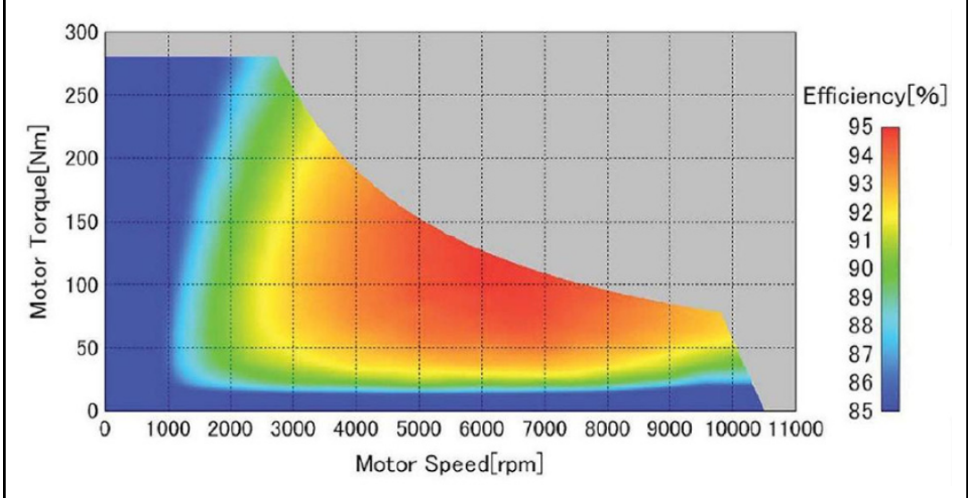

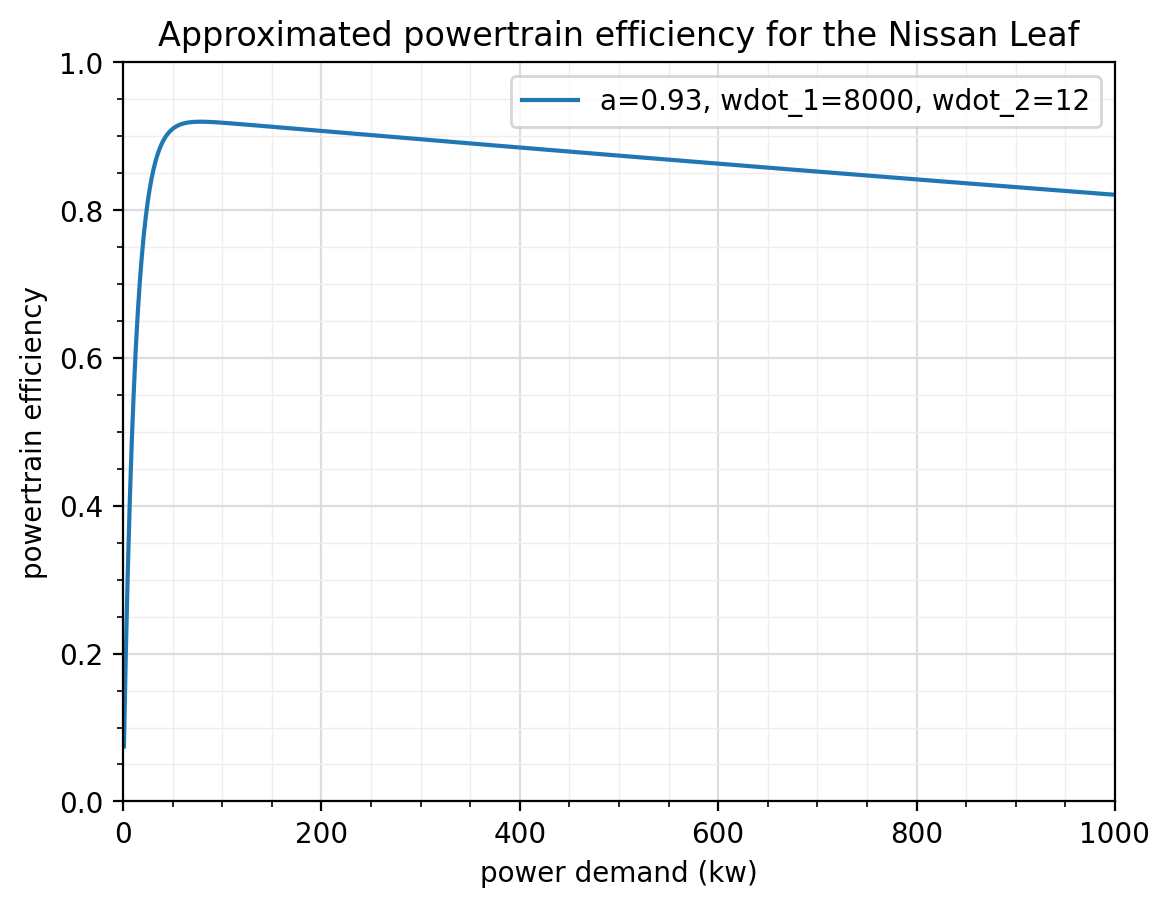

In [393]:
leaf_powertrain_params = {"a": 0.93, "wdot_1": 8000, "wdot_2": 12}
plt.plot(
    w_veh,
    [instantaneous_eta_tr(w, **leaf_powertrain_params) for w in w_veh],
    label="a=0.93, wdot_1=8000, wdot_2=12",
)

plt.xlabel("power demand (kw)")
plt.ylabel("powertrain efficiency")
hw_utils.nice_grid(plt)
plt.xlim(0, 1000)
plt.ylim(0, 1)
plt.legend()
plt.title("Approximated powertrain efficiency for the Nissan Leaf");

The regenerative braking model I am using is adopted from Fiori et al. It's a pretty simple model. When acceleration is negative, power due to acceleration becomes a "negative" load and is recovered with an efficiency η<sub>rb</sub> that is calculated as a function of the negative vehicle acceleration. Let's first take a look at how η<sub>rb</sub> relates to deceleration magnitude.

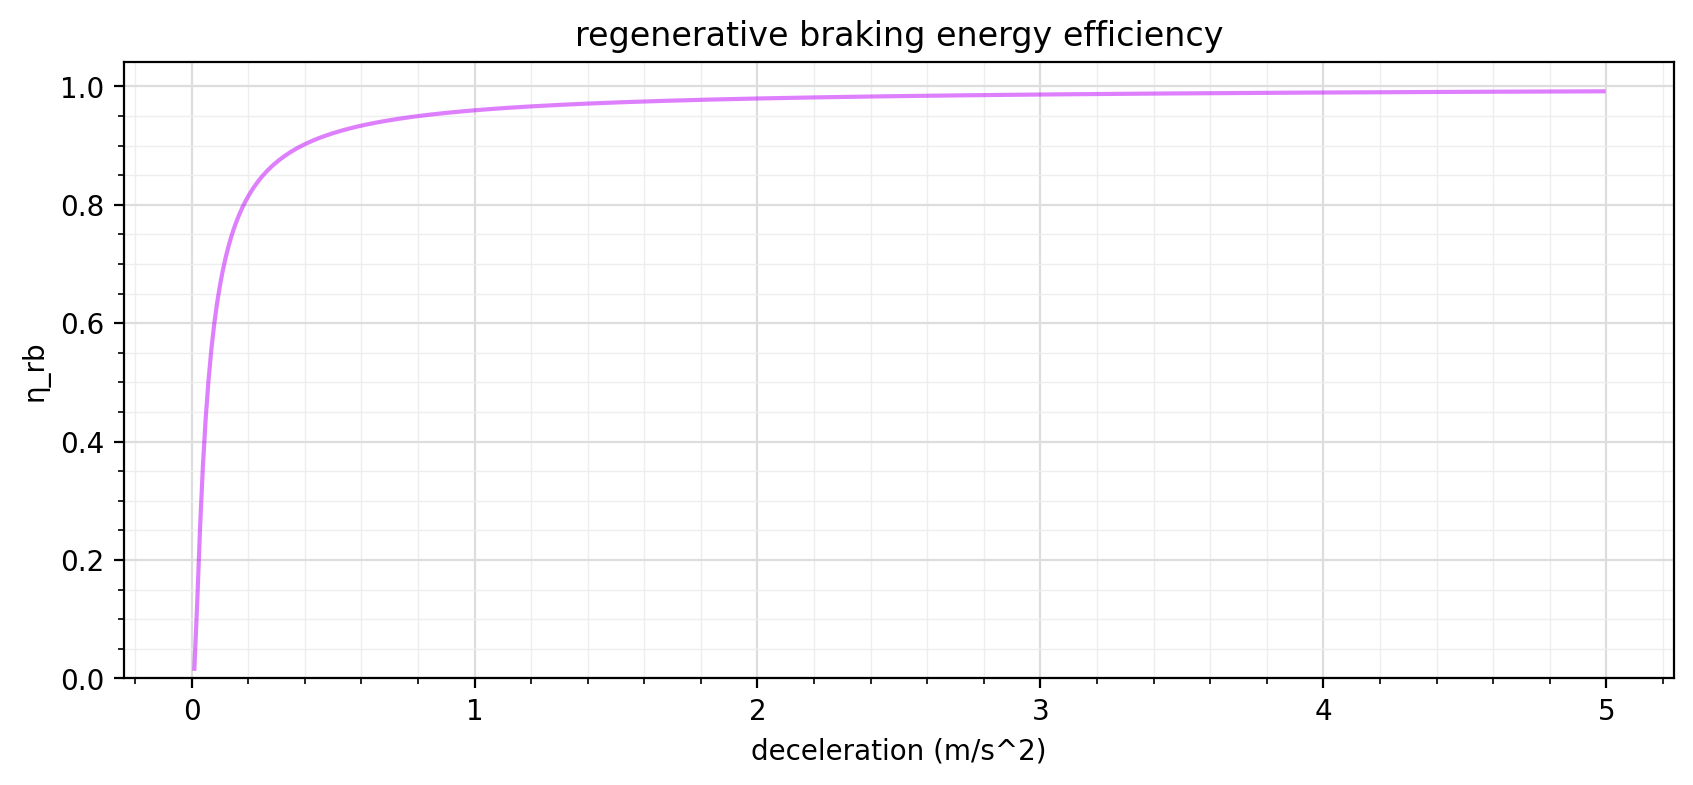

In [414]:
decel = np.arange(0.01, 5, 0.01)
plt.figure(figsize=(10, 4))
color_rgb = hsv_to_rgb([0.1, 0.8, 1])
plt.plot(
    decel,
    [calculate_regen_braking_efficiency(d) for d in decel],
    alpha=0.5,
    color='xkcd:bright purple'
)
plt.ylim(0)
hw_utils.nice_grid(plt)
plt.ylabel('η_rb')
plt.title('regenerative braking energy efficiency')
plt.xlabel('deceleration (m/s^2)');

Ok great, that looks the same as Fiori. Now let's get after it....

In [483]:
vehicle_leaf = copy.deepcopy(vehicle_outback)
vehicle_leaf["A_front"] = 2.23
vehicle_leaf["mass"] = 2044.8
vehicle_leaf["C_drag"] = 0.28
vehicle_leaf["Wdot_access"] = 490  # 490 / 0.7 = 700

vehicle_versa = copy.deepcopy(vehicle_outback)
vehicle_versa["A_front"] = 2.11
vehicle_versa["mass"] = 1569.9
vehicle_versa["C_drag"] = 0.31

vehicle_leaf = calculate_loads(vehicle_leaf, leaf_powertrain_params, True)
vehicle_versa = calculate_loads(vehicle_versa, {}, False)


for i in [0, 1]:
    pos_wdot = [max(w, 0) for w in vehicle_leaf["Wdot"][i]]
    neg_wdot = [min(w, 0) for w in vehicle_leaf["Wdot"][i]]
    plt.figure(figsize=(10, 2))
    plt.plot(
        cycle["time"][i],
        cycle["mps"][i],
        color="xkcd:navy",
        linewidth=0.5,
        alpha=0.5,
        label="vehicle speed [m/s]",
    )
    plt.fill_between(
        cycle["time"][i],
        pos_wdot,
        [0] * len(cycle["time"][i]),
        alpha=0.3,
        color="xkcd:wine",
        label="traction mode [kW]",
    )
    plt.fill_between(
        cycle["time"][i],
        neg_wdot,
        [0] * len(cycle["time"][i]),
        alpha=0.3,
        color="xkcd:apple green",
        label="regen braking mode [kW]",
    )
    plt.xlim(0, len(cycle["time"][i]))
    # plt.plot(
    #     cycle["time"][i],
    #     vehicle_versa["Wdot"][i],
    #     linewidth=2,
    #     color="xkcd:wine",
    #     alpha=0.5,
    # )
    plt.ylabel("kW and m/s")
    plt.legend(prop={"size": 4})
    plt.title(f"power profile for {cycle['name'][i]} cycle")

Add state of charge...

    hw_utils.nice_grid(plt)

SyntaxError: invalid syntax (2685859824.py, line 56)